## Resources/references: 

* https://jalammar.github.io/illustrated-transformer/ - a nice guide
* https://arxiv.org/abs/1706.03762 - Attention Is All You Need
* http://nlp.seas.harvard.edu/2018/04/03/attention.html - The paper above illustrated in pytorch
* https://nextjournal.com/gkoehler/pytorch-mnist - some helper functions for MNIST



In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torchvision as tv

import random

from matplotlib import pyplot as plt

device = "cuda" if t.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Connect the notebook to your google drive so that we can save files.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Reproducibility

Set up random seeds

In [3]:
random.seed(42)
np.random.seed(42)
t.random.manual_seed(42)

# Defining the model

Individual self-attention head

In [9]:
from torch.nn.modules.module import T
class SelfAttentionHead(nn.Module):

  def __init__(self, emb_size, QKV_size):
    super().__init__()

    self.emb_size = emb_size
    self.WQ, self.WK, self.WV = nn.Parameter(t.randn(emb_size, QKV_size)), \
                                nn.Parameter(t.randn(emb_size, QKV_size)), \
                                nn.Parameter(t.randn(emb_size, QKV_size))


  def forward(self, x):
    '''x - a tensor [batch size, sequence_len, embedding size], returns self-attention transformed x'''

    Q = t.matmul(x, self.WQ)
    K = t.matmul(x, self.WK)
    V = t.matmul(x, self.WV)

    attention_matrix = nn.functional.softmax((t.matmul(Q, t.transpose(K, 1, 2)))/np.sqrt(K.shape[2]), dim=1)

    transformed_x = attention_matrix @ V

    return transformed_x

## Example Non-batched
#tst_sa = SelfAttentionHead(10, 5).to(device)
#tst_sa(t.randn(15, 10).to(device)).shape # Gives 15, 5

## Example
tst_sa = SelfAttentionHead(10, 5).to(device)
tst_sa(t.randn(7, 15, 10).to(device)).shape # Gives 7, 15, 5 

torch.Size([7, 15, 5])

In [10]:
class MultiheadAttention(nn.Module):

  def __init__(self, emb_size, QKV_size, n_heads, transformed_size):
    super().__init__()

    self.W0 = nn.Parameter(t.randn(QKV_size * n_heads, transformed_size))
    self.n_heads = n_heads
    self.emb_size = emb_size
    self.transformed_size = transformed_size

    self.heads = nn.ModuleList([SelfAttentionHead(emb_size, QKV_size) for _ in range(n_heads)])

  def forward(self, x):
    '''x - a tensor [batch size, sequence_length, embedding size], returns multihead self-attention transformed x'''

    head_activations = [h(x) for h in self.heads]
    stacked_activations = t.cat(head_activations, dim = 2)

    return stacked_activations @ self.W0


## Example
tst_mha = MultiheadAttention(10, 5, 6, 13).to(device)
tst_mha(t.randn(13, 15, 10).to(device)).shape # Gives 13, 15, 13

torch.Size([13, 15, 13])

In [11]:
class MultiheadAttentionLayer(nn.Module):

  def __init__(self, emb_size, QKV_size, n_heads, seq_length):

    # Note that we have no 'transformed size' since it's going to stay the same now

    super().__init__()

    self.multihead = MultiheadAttention(emb_size, QKV_size, n_heads, emb_size)
    
    self.ffnn = nn.Linear(emb_size, emb_size)
    self.layer_norm_1 = nn.LayerNorm((seq_length, emb_size))
    self.layer_norm_2 = nn.LayerNorm((seq_length, emb_size))

  def forward(self, x):

    multihead_transformed = self.multihead(x)
    multihead_with_residual = multihead_transformed + x
    normalized_1 = self.layer_norm_1(multihead_with_residual)
    ffnn_transformed = F.relu(self.ffnn(normalized_1))
    ffnn_trans_with_residual = ffnn_transformed + normalized_1
    normalized_2 = self.layer_norm_2(ffnn_trans_with_residual)

    return normalized_2

## Example
tst_mhl = MultiheadAttentionLayer(emb_size=10, QKV_size=5, n_heads=6, seq_length=15).to(device)
tst_mhl(t.randn(3, 15, 10).to(device)).shape # Gives 3, 15, 10

torch.Size([3, 15, 10])

In [12]:
class MultiheadAttentionNetwork(nn.Module):

  def __init__(self, emb_size, QKV_size, n_heads, seq_length, n_layers):
    
    super().__init__()

    self.layers = nn.ModuleList([MultiheadAttentionLayer(emb_size, QKV_size, n_heads, seq_length) for _ in range(n_layers)])

  def forward(self, x):

    for l in self.layers:
      ## Your code here
      x = l(x)

    return x

## Example
tst_mhn = MultiheadAttentionNetwork(emb_size=10, QKV_size=5, n_heads=6, seq_length=15, n_layers=7).to(device)
tst_mhn(t.randn(3, 15, 10).to(device)).shape # Gives 3, 15, 10

torch.Size([3, 15, 10])

## Let's apply our model to something silly (MNIST)

In [13]:
# TRAINING PARAMETERS

BATCH_SIZE = 128
IMAGE_SIZE = 28

NUM_EPOCHS = 10

In [14]:
train_data = tv.datasets.MNIST(F"/content/gdrive/My Drive/Transformers From Scratch/", train=True, download=True,
                             transform=tv.transforms.Compose([
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])) # 60000

test_data = tv.datasets.MNIST(F"/content/gdrive/My Drive/Transformers From Scratch/", train=False, download=True,
                             transform=tv.transforms.Compose([
                               tv.transforms.ToTensor(),
                               tv.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])) # 10000

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw/train-images-idx3-ubyte.gz to /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw/train-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/gdrive/My Drive/Transformers From Scratch/MNIST/raw



# Training example example

7

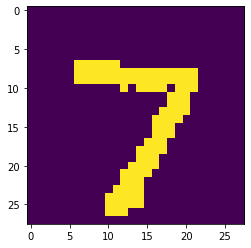

In [15]:
plt.figure()
plt.imshow((test_data[0][0] > 0).view((28, 28)))
test_data[0][1] # Label

In [16]:
train_loader = t.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = t.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Example usage
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape, example_targets.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


Create a model appropriate for our task

In [17]:
class PositionalEncoding(nn.Module): # from https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        position = t.arange(max_len).unsqueeze(1)
        div_term = t.exp(t.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = t.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = t.sin(position * div_term)
        pe[0, :, 1::2] = t.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return x

In [18]:
class MNIST_transformer_classifier(nn.Module):

  def __init__(self, emb_size, QKV_size, n_heads, n_layers):

    super().__init__()

    self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=emb_size)
    self.attn_net = MultiheadAttentionNetwork(emb_size=emb_size, QKV_size=QKV_size, 
                                              n_heads=n_heads, seq_length=28 * 28 + 1, 
                                              n_layers=n_layers)
    self.pe = PositionalEncoding(emb_size)

    self.out = nn.Linear(emb_size, 10)

  def forward(self, X):

    '''X - [batch_size, 764] - binarized mnist images'''

    X_with_cls = t.cat([t.ones(X.shape[0], 1).long().to(device) * 2, X], dim=1) # adding a CLS token

    X_embedded = self.embedding(X_with_cls)
    X_embedded = self.pe(X_embedded)

    X_transformed = self.attn_net(X_embedded)
    X_cls_tokens = X_transformed[:, 0, :]
    X_logits = self.out(X_cls_tokens)
    
    return X_logits

our_classifier = MNIST_transformer_classifier(emb_size=10, QKV_size=5, n_heads=3, n_layers=3)
our_classifier.to(device);


In [19]:
def prep_batch(X, Y):
  X = X.view(BATCH_SIZE, -1)
  X = (X > 0).long()
  X, Y = t.LongTensor(X).to(device), t.LongTensor(Y).to(device)
  return X, Y

In [20]:
def calculate_test_set_accuracy(model, test_set_dataloader):
  batches = enumerate(test_loader)

  correct = 0
  total = 0
  with t.no_grad():
    for batch_idx, (X, Y) in batches:
      if list(X.shape) != [BATCH_SIZE, 1, 28, 28]:
        continue

      X, Y = prep_batch(X, Y)
      logits = our_classifier(X)
      predictions = logits.argmax(dim=1)
      correct += (predictions == Y).long().sum()
      total += BATCH_SIZE

  return correct / total



## Writing a training loop

In [ ]:
optimizer = t.optim.Adam(our_classifier.parameters())
loss_fn = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):

  batches = enumerate(train_loader)

  for batch_idx, (X, Y) in batches:
    optimizer.zero_grad()
    if list(X.shape) != [BATCH_SIZE, 1, 28, 28]:
      continue

    X, Y = prep_batch(X, Y)
    logits = our_classifier(X)
    loss = loss_fn(logits, Y)
    loss.backward()

    optimizer.step()

    if not (batch_idx % 50):
      print("Processed {} batches.".format(batch_idx))


  print("{} epochs passed".format(epoch+1))
  

Processed 0 batches.
Processed 50 batches.
Processed 100 batches.
Processed 150 batches.
Processed 200 batches.
Processed 250 batches.
Processed 300 batches.
Processed 350 batches.
Processed 400 batches.
Processed 450 batches.
1 epochs passed
Processed 0 batches.
Processed 50 batches.
Processed 100 batches.
Processed 150 batches.
Processed 200 batches.
Processed 250 batches.
Processed 300 batches.
Processed 350 batches.
Processed 400 batches.
Processed 450 batches.
2 epochs passed
Processed 0 batches.
Processed 50 batches.
Processed 100 batches.
Processed 150 batches.
Processed 200 batches.
Processed 250 batches.
Processed 300 batches.
Processed 350 batches.
Processed 400 batches.
Processed 450 batches.
3 epochs passed
Processed 0 batches.
Processed 50 batches.
Processed 100 batches.
Processed 150 batches.
Processed 200 batches.
Processed 250 batches.
Processed 300 batches.
Processed 350 batches.
Processed 400 batches.
Processed 450 batches.
4 epochs passed
Processed 0 batches.
Process

In [ ]:
accuracy = calculate_test_set_accuracy(our_classifier, test_loader)
print(accuracy)

tensor(0.9024, device='cuda:0')
